# 2D model with preprocessing

## Colab integration

In [1]:
RUNNING_IN_COLAB = True
Branch = "new-unet"

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/nicomem/imed-project.git'
    REPO_DIR = 'imed-project'
    DATA_URL = 'https://drive.google.com/uc?id=1onHHWIhkhN5xYMit0rhhtVXlJrAlzCit'
    
    from pathlib import Path

    %cd /content

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone {REPO_URL} {REPO_DIR}
    
    %cd {REPO_DIR}
    !git checkout $Branch
    # Install requirements
    !pip install -r requirements.txt | grep -v 'Requirement already satisfied'
    !pip install gdown | grep -v 'Requirement already satisfied'
    
    import gdown
    if not Path('data.zip').is_file():
        gdown.download(DATA_URL, 'data.zip', quiet=False)
    
    if not Path('data').is_dir():
        !unzip data.zip
    
    %cd notebooks
    !ls

/content
Cloning into 'imed-project'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 99 (delta 55), reused 58 (delta 21), pack-reused 0
Unpacking objects: 100% (99/99), done.
/content/imed-project
Branch 'new-unet' set up to track remote branch 'new-unet' from 'origin'.
Switched to a new branch 'new-unet'


Downloading...
From: https://drive.google.com/uc?id=1onHHWIhkhN5xYMit0rhhtVXlJrAlzCit
To: /content/imed-project/data.zip
2.24GB [00:23, 95.6MB/s]


Archive:  data.zip
   creating: data/
   creating: data/3DT1/
  inflating: data/3DT1/0.nii.gz      
  inflating: data/3DT1/100.nii.gz    
  inflating: data/3DT1/101.nii.gz    
  inflating: data/3DT1/102.nii.gz    
  inflating: data/3DT1/103.nii.gz    
  inflating: data/3DT1/104.nii.gz    
  inflating: data/3DT1/105.nii.gz    
  inflating: data/3DT1/106.nii.gz    
  inflating: data/3DT1/107.nii.gz    
  inflating: data/3DT1/108.nii.gz    
  inflating: data/3DT1/109.nii.gz    
  inflating: data/3DT1/11.nii.gz     
  inflating: data/3DT1/110.nii.gz    
  inflating: data/3DT1/112.nii.gz    
  inflating: data/3DT1/113.nii.gz    
  inflating: data/3DT1/114.nii.gz    
  inflating: data/3DT1/115.nii.gz    
  inflating: data/3DT1/116.nii.gz    
  inflating: data/3DT1/126.nii.gz    
  inflating: data/3DT1/132.nii.gz    
  inflating: data/3DT1/137.nii.gz    
  inflating: data/3DT1/144.nii.gz    
  inflating: data/3DT1/17.nii.gz     
  inflating: data/3DT1/19.nii.gz     
  inflating: data/3DT1/2.n

## Imports

In [3]:
# 3rd-party imports
import numpy as np
import nibabel as nib
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import keras_unet
from tensorflow import keras

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Get dataset & split train/test

In [4]:
from utils.load_data import get_dataset, SlicesSequence, CachedSlicesSequence

train_nib, val_nib = get_dataset('../data', verbose=True)

Number of files for each category: 60
Train/val split: 54 / 6


## Load data

In [5]:
batch_size = 32
shuffle = True
preprocess = True
target_height = 256
target_width = 256
img_size = (target_height, target_width)
num_classes = 1

train_seq_uncached = SlicesSequence(train_nib,
                                    target_height, target_width, 
                                    batch_size, shuffle)
train_seq = CachedSlicesSequence(train_seq_uncached, batch_size, shuffle, preprocess)
len(train_seq)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


100

In [6]:
val_seq_uncached = SlicesSequence(val_nib,
                                  target_height, target_width,
                                  batch_size, shuffle)
val_seq = CachedSlicesSequence(val_seq_uncached, batch_size, shuffle, preprocess)
len(val_seq)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


11

## Prepare the model

In [7]:
from keras_unet.models import custom_unet

# Beware 3 channels because of preprocessing
input_shape = (target_height, target_width, 3)
keras.backend.clear_session()
model = custom_unet(
    input_shape,
    num_classes=1,
    use_batch_norm=True,
    filters=32,
    num_layers=3,
    #dropout=0.3,
    output_activation='sigmoid'
)

In [19]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [22]:
from keras.callbacks import ModelCheckpoint

model_filename = 'segm_model_prepro_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=dice_coef_loss,
    #loss="binary_crossentropy",
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [17]:
train_seq.Y = train_seq.Y.astype(np.float32)
val_seq.Y = val_seq.Y.astype(np.float32)

In [26]:
history = model.fit(train_seq, epochs=15, validation_data=val_seq, callbacks=[callback_checkpoint])

Epoch 1/15
100/100 [==============================] - 65s 651ms/step - loss: 0.0095 - recall_2: 0.8143 - precision_2: 0.8899 - val_loss: 0.0136 - val_recall_2: 0.5337 - val_precision_2: 0.9780

Epoch 00001: val_loss did not improve from 0.01148
Epoch 2/15
100/100 [==============================] - 65s 646ms/step - loss: 0.0099 - recall_2: 0.8037 - precision_2: 0.8842 - val_loss: 0.0121 - val_recall_2: 0.5996 - val_precision_2: 0.9670

Epoch 00002: val_loss did not improve from 0.01148
Epoch 3/15
100/100 [==============================] - 65s 646ms/step - loss: 0.0094 - recall_2: 0.8138 - precision_2: 0.8938 - val_loss: 0.0124 - val_recall_2: 0.6149 - val_precision_2: 0.9616

Epoch 00003: val_loss did not improve from 0.01148
Epoch 4/15
100/100 [==============================] - 65s 646ms/step - loss: 0.0090 - recall_2: 0.8239 - precision_2: 0.8940 - val_loss: 0.0137 - val_recall_2: 0.5325 - val_precision_2: 0.9686

Epoch 00004: val_loss did not improve from 0.01148
Epoch 5/15
100/100 [

## Check the results

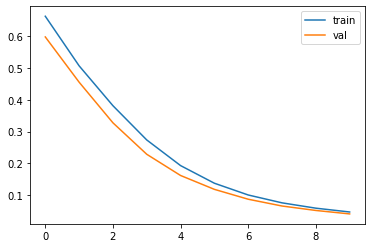

In [11]:
def rolling_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

ravg_w = 1

plt.plot(rolling_average(history.history['loss'], ravg_w), label='train')

plt.plot(rolling_average(history.history['val_loss'], ravg_w), label='val')

plt.legend()
plt.show()

In [12]:
Y_pred = model.predict(val_seq.X)
print(Y_pred.shape)

(358, 256, 256, 1)


163
284
14
269
305
312
65
274
318
299


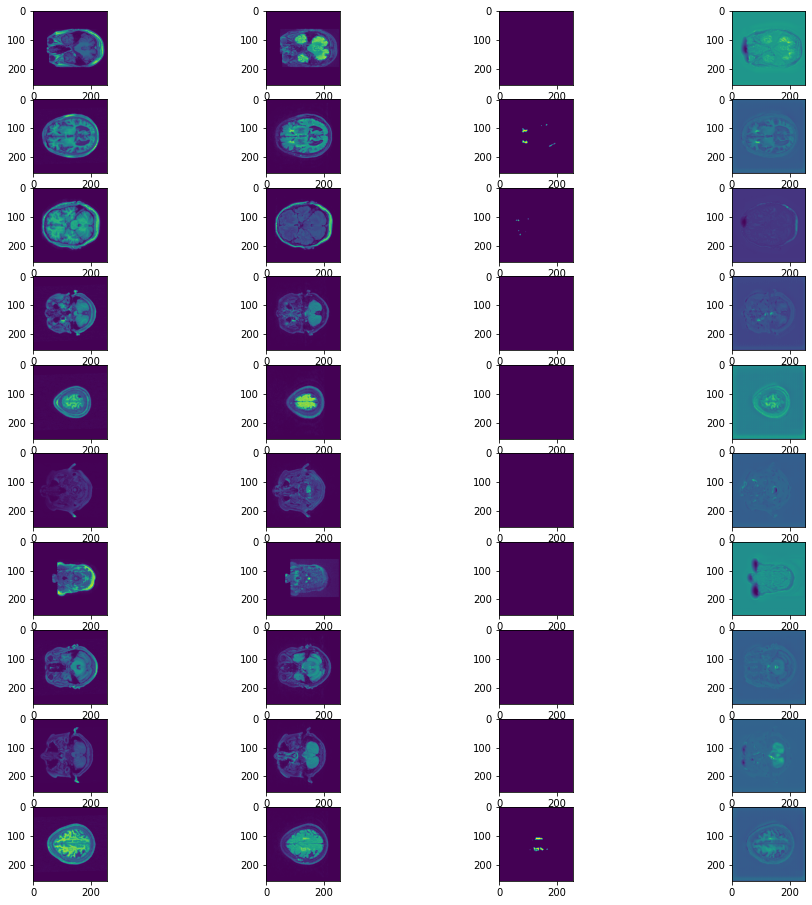

In [27]:
N = 10
i_samples = np.random.choice(np.arange(0, Y_pred.shape[0]), size=N, replace=False)

plt.figure(figsize=(16,16))
for i, i_sample in enumerate(i_samples):
  x = val_seq.X[i_sample]
  y = val_seq.Y[i_sample]
  print(i_sample)
  plt.subplot(N, 4, 4*i+1)
  plt.imshow(x[...,0])

  plt.subplot(N, 4, 4*i+2)
  plt.imshow(x[...,1])

  plt.subplot(N, 4, 4*i+3)
  plt.imshow(np.reshape(y, (target_height, target_width)))

  plt.subplot(N, 4, 4*i+4)
  plt.imshow(np.reshape(Y_pred[i_sample], (target_height, target_width)))